# Homework 4

**Due: 03/01/2018** (Thursday 1st March at 11:59pm).

## Instructions

+ In any case, develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - you can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope. 

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:**Gourav
+ **Last Name:**Jhanwar
+ **Email:**gjhanwar@purdue.edu

## Readings

Before attempting the homework, it is probably a good idea to:
+ Read chapter 1, 2 of [Rasmussen](http://www.gaussianprocess.org/gpml/chapters/);
+ Review the slides of lectures 10, 11, & 12; and
+ Review the corresponding lecture handouts.

## Problem 1 - The Mauna Loa CO$_2$ data set

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start on March 1958 and go all the way to Janurary 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python script below, downloads and plots the data set.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import GPy
import scipy.linalg
%matplotlib inline
from sklearn.linear_model import ARDRegression
import cPickle as pickle

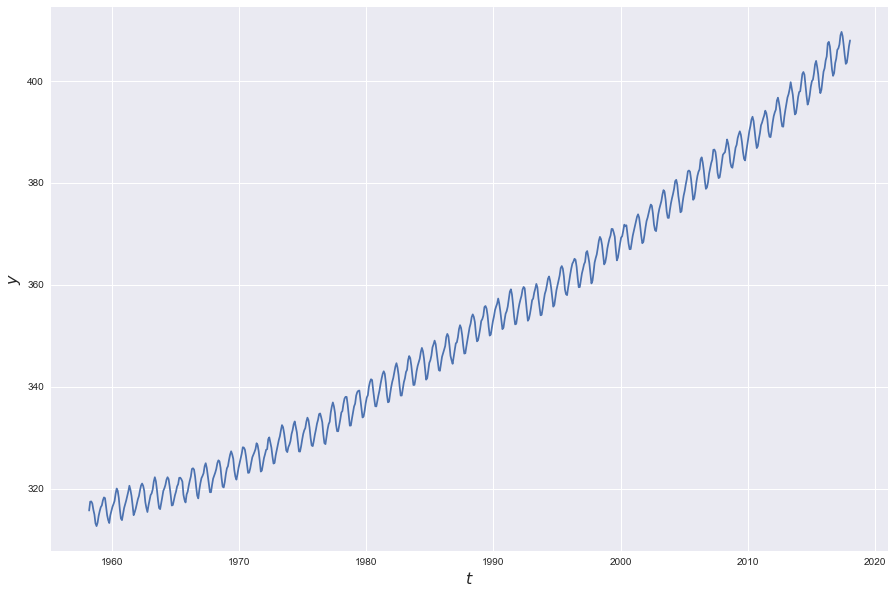

In [84]:
#load data 
data = np.loadtxt('mauna_loa_co2.txt')
t = data[:, 2][:, None]  #time (in decimal dates)
y = data[:, 4]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, figsize = (15, 10))
ax.plot(t, y)
ax.set_xlabel('$t$', fontsize = 16)
ax.set_ylabel('$y$', fontsize = 16)

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since the vast majority of the population inhabits the Northen hemisphere, fuel consumption goes up during the Northen winters. Our goal is to study this data set with the regression techniques we learned in class. Specifically we would like to provide an answer to the following task.
+ **Task 1** Predict the evolution of the CO2 levels from Feb 2018 to Feb 2028 (ten years from now).
+ **Task 2**  Quantify our uncertainty about this prediction.

### Part  A 

Use any Bayesian linear regression technique discussed in class to construct a map between $t$ and $y$. State clearly which basis functions you use and why. We suggest you use automatic relevance determination (ARD) as implemented in [scikitlearn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html).

The choice of the candidate basis functions is completely up to you. We expect you to justify your choices and interpret your findings. E.g., "I picked these basis functions because I expected this to happen", or "ARD finally selected these basis functions and this can be interpreted as this and that." 

best sigma: 0.627706933373
(1000, 1) (1000,)


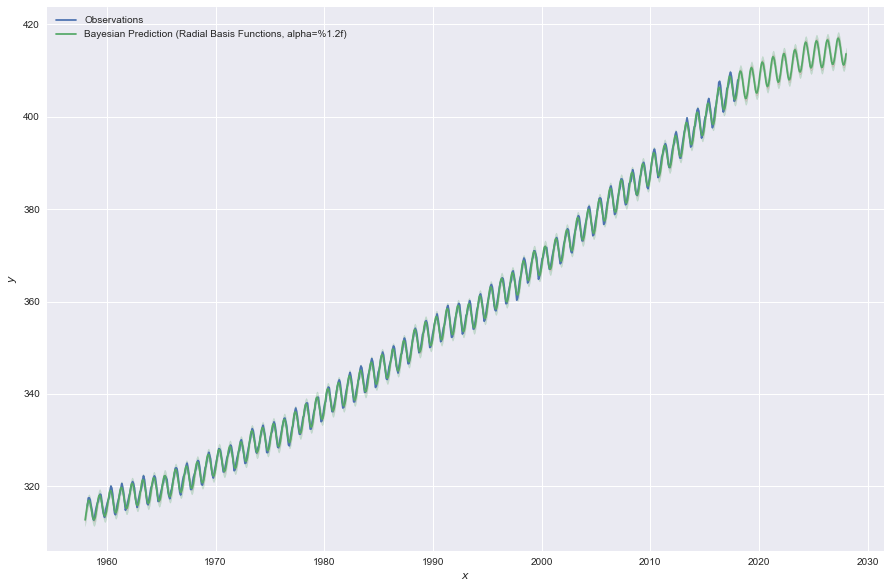

In [152]:
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in xrange(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res

# Here is a class for the Fourier basis:
class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])

X_p = np.linspace(1958, 2028, 1000)[:, None]
num_terms=261
L=204
phi = FourierBasis(num_terms,L)
Phi_p = compute_design_matrix(X_p, phi)
Phi = compute_design_matrix(t, phi)
regressor = ARDRegression()
regressor.fit(Phi, y)
# They are using different names:
sigma = np.sqrt(1. / regressor.alpha_)
print 'best sigma:', sigma
alpha_l = regressor.lambda_
#print 'best alpha:', alpha_l
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha_l * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound
print X_p.shape,Y_l.shape
fig, ax = plt.subplots(1, figsize = (15, 10))
ax.plot(t, y, markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p, label='Bayesian Prediction (Radial Basis Functions, alpha=%1.2f)')
ax.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_l, Y_l_ep, color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(X_p.flatten(), Y_u_ep, Y_u, color=sns.color_palette()[1], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

*Enter your model description/solution here. Delete that ``<br>`` line (it just makes some white space). Insert any additional code blocks / cells necessary for your answer.* 
<br>
I selected Fourier basis function with larger length scale in order to consider the rising trend of the data.<br>
I increased the number of basis functions in order to capture the wiggles present in the data.<br>
I used ARD to get the best alpha and sigma.

### Part B

In this problem you have to do exactly the same as in problem 1, but using Gaussian process regression using ``GPy``. 


Name : GP regression
Objective : 969.841221379
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  GP_regression.                            |           value  |  constraints  |  priors
  sum.rbf.variance                          |   2500.00180161  |      +ve      |        
  sum.rbf.lengthscale                       |      99.9847667  |      +ve      |        
  sum.mul.rbf.variance                      |   4.75778240393  |      +ve      |        
  sum.mul.rbf.lengthscale                   |   90.0016678598  |      +ve      |        
  sum.mul.periodic_exponential.variance     |   3.21026370257  |      +ve      |        
  sum.mul.periodic_exponential.lengthscale  |  0.208548685367  |      +ve      |        
  sum.mul.periodic_exponential.period       |  0.999820390055  |      +ve      |        
  Gaussian_noise.variance                   |  0.605164547302  |      +ve      |        
> writing model to file: surrogate.pcl


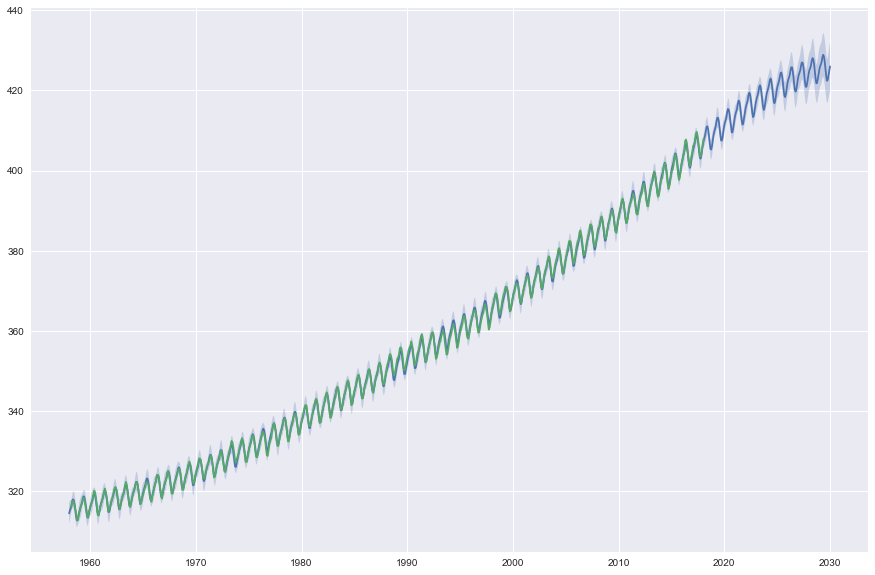

In [145]:
np.random.seed(1345678)


#num_sim = 100
t1=data[:,2]
y1=data[:,4][:,None]
# Generate the input data (needs to be column matrix)
X=t

# Evaluate our amazing code at these points:
Y=y1

# Pick a covariance function
k1 = GPy.kern.RBF(input_dim=1, variance=2500, lengthscale=100)
k2 = GPy.kern.RBF(input_dim=1, variance=4 , lengthscale=90)\
     * GPy.kern.PeriodicExponential(input_dim=1, variance=2, lengthscale=1.0,period=1.0)

k=k1+k2
# Construct the GP regression model
m = GPy.models.GPRegression(X, Y, k)
m.optimize()
# That's it. Print some details about the model:
print m
m.optimize()
# Now we would like to make some predictions
# Namely, we wish to predict at this dense set of points:
X_p = np.linspace(1958, 2030, 1000)[:, None]

# We can make predictions as follows
Y_p, V_p = m.predict(X_p) # Y_p = mean prediction, V_p = predictive variance
# Here is the standard deviation:
S_p = np.sqrt(V_p)
# Lower predictive bound
Y_l = Y_p - 2. * S_p
# Upper predictive bound
Y_u = Y_p + 2. * S_p

fig, ax = plt.subplots(1, figsize = (15, 10))
ax.plot(X_p, Y_p, label='Predictive mean')
ax.fill_between(X_p.flatten(), Y_l.flatten(), Y_u.flatten(), alpha=0.25, label='Predictive error bars')
ax.plot(t, y, markeredgewidth=2, label='Observed data')

# Write the model to a file 
print '> writing model to file: surrogate.pcl'
#with open('surrogate.pcl', 'wb') as fd:
#    pickle.dump(m, fd)

*Enter your model description/solution here. Delete that ``<br>`` line (it just makes some white space). Insert any additional code blocks / cells necessary for your answer.* 
<br>
The covariance kernel used in the above code consisit of two different kernels:<br>
1)RBF kernel in order to account the rising trend of data<br>
2)RBF* periodic kernel in order to capture the wiggles present in data<br>
Also we can see that uncertainity in predicting the $CO_2$ level from 2018 to 2028 increases.

## Problem 2 - Stochastic model for permeability of oil reservoir

The permeability of the soil is one of the largest unknowns in modeling underground flows. Here, you will create a 2D model of permeability that can be used for propagating uncertainties or as a starting point for model calibration. This is the information that is available to you:
+ You need to build a stochastic model for permeability with as low dimensionality as possible.
+ You need to be able to sample random permeability fields from this model.
+ The permeability is strictly positive.
+ The 2D domain you should consider is $[0, 356]\times[0,670]$ (in meters).
+ Our geologist gave us her best estimate about the permeability field. We have put the results for you in a data file and we show you how to load it and plot it below.
+ When asked how sure she is about the prediction, the geologist gave a standard deviation of about 3.2 on the logarithm of the permeability.
+ She also believes that there are two lengthscales: 50 meters and 10 meters.

Do the following:

a. Write down the mathematical form of the best stochastic model for the permeability you can come up with using the information above. Are you going to use a GP? Are you going to consider a transformed version of the GP? What would the mean be? What would the covariance function be? What would the parameters of the covariance function be?

b. Construct the Karhunen-Loeve expansion of the field using the code provided in lecture 12. You should: 1) use enough quadrature points so that you get a converged Nystrom approximation; 2) use enough terms to cover $95\%$ of the fields energy; 3) Plot the egenvalues of KLE; 4) Plot the first six eigenfunctions of KLE; 5) Plot six samples of the random field.

c. You sent a crew to go and make some measurements of the permeability. Repeate everything you did in b. making use of the new data:
 

|$x_1$ |$x_2$ | $\log K(x_1, x_2)$ |
|------|------|--------------------|
|100.  |200.  | -13.2              |
|300.  |500.  | -25.3              |
 
Here is the mean field provided by the geologist:

SOLUTION: A Gaussian process (GP) is a generalization of a multivariate Gaussian distribution to
*infinite* dimensions.

GP is used as a stochastic model for the permeability in the given problem.

It essentially defines a probability measure on a function space.
When we say that $f(\cdot)$ is a GP, we mean that it is a random variable that is actually
a function.
Mathematically, we write:
\begin{equation}
f(\cdot) | m(\cdot), k(\cdot, \cdot) \sim \mbox{GP}\left(f(\cdot) | m(\cdot), k(\cdot, \cdot) \right),
\end{equation}
where 
$m:\mathbb{R}^d \rightarrow \mathbb{R}$ is the *mean function* and 
$k:\mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$ is the *covariance function*.
So, compared to a multivariate normal we have:

+ A random function $f(\cdot)$ instead of a random vector $\mathbf{x}$.
+ A mean function $m(\cdot)$ instead of a mean vector $\boldsymbol{\mu}$.
+ A covariance function $k(\cdot,\cdot)$ instead of a covariance matrix $\mathbf{\Sigma}$.

Squared expnential (SE) is the most commonly used covariance function.


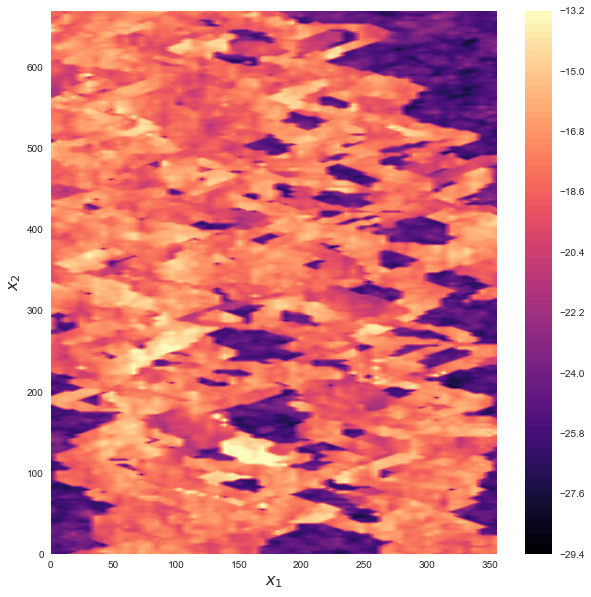

In [6]:
K = np.loadtxt('spe10_permx.dat').T
x1 = np.linspace(0, 356, 60)
x2 = np.linspace(0, 670, 220)
X1, X2 = np.meshgrid(x1, x2)
fig, ax = plt.subplots(1, figsize = (10, 10))
im=ax.contourf(X1, X2, np.log(K), 100, cmap = 'magma')
fig.colorbar(im, ax=ax)
ax.set_xlabel('$x_1$', fontsize = 16)
ax.set_ylabel('$x_2$', fontsize = 16)

  Exponential.  |  value  |  constraints  |  priors
  variance      |  10.24  |      +ve      |        
  lengthscale   |   (2,)  |      +ve      |        


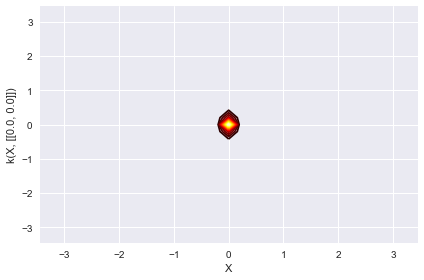

In [120]:
dim = 2
# The variance of the covariance kernel
variance = 3.2*3.2
# The lengthscale of the covariance kernel
ell1= 50./356
ell2= 10./670
# Generate the covariance object
k = GPy.kern.Exponential(dim, ARD=True, variance=variance, lengthscale=[ell1,ell2])
# Print it
print k
# and plot it
k.plot()
# To gaurantee reproducibility
np.random.seed(1)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
# Compute the covariance function at these points
nugget = 1e-6 # This is a small number required for stability
C = k.K(X_all) + nugget * np.eye(X_all.shape[0])
# Compute the Cholesky of the covariance
L = np.linalg.cholesky(C)

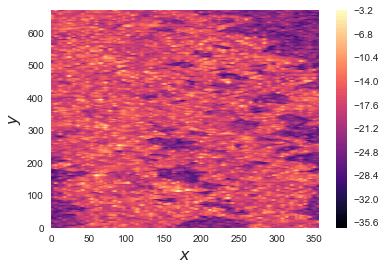

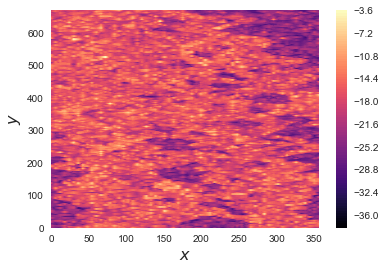

In [122]:
m=np.log(K)
# Number of samples to take
num_samples = 2
for i in xrange(num_samples):
    g = np.dot(L, np.random.randn(L.shape[0]))
    Lz = g.reshape(X1.shape)
    f=m + Lz
    
    fig, ax = plt.subplots()
    im=ax.contourf(X1, X2, f.reshape(m.shape), 100, cmap = 'magma')
    fig.colorbar(im, ax=ax)
    #ax.plot(X, f, color=sns.color_palette()[1], linewidth=1)
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)

In [159]:
import numpy as np
import scipy
class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, Y=None):
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            gpr = GPy.models.GPRegression(X, Y[:, None], k)
            gpr.likelihood.variance = 1e-12
            self.gpr = gpr
            Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            nq = self.Xq.shape[0]
            Xf = np.vstack([self.Xq, x])
            m, C = self.gpr.predict(Xf, full_cov=True)
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:, :].flatten()
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum("i,ji,j,rj->ri", 1. / self.lam, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + np.dot(phi, xi * self.sqrt_lam)

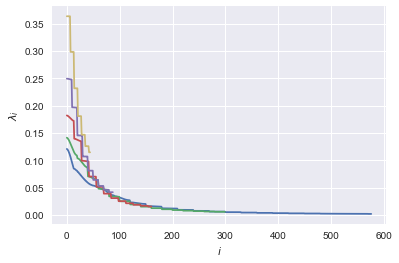

In [160]:
dim = 2
# The variance of the covariance kernel
variance = 3.2**2
# The lengthscale of the covariance kernel
ell1= 50./356
ell2= 10./670
k = GPy.kern.Exponential(dim, ARD=True, variance=variance, lengthscale=[ell1,ell2])
kle1 = KarhunenLoeveExpansion(k, nq=950, alpha=0.95)
kle2 = KarhunenLoeveExpansion(k, nq=400, alpha=0.95)
kle3 = KarhunenLoeveExpansion(k, nq=200, alpha=0.95)
kle4 = KarhunenLoeveExpansion(k, nq=100, alpha=0.95)
kle5 = KarhunenLoeveExpansion(k, nq=50, alpha=0.95)
x = np.linspace(0, 1, 32)
X1, X2 = np.meshgrid(x, x)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
#print 'Number of terms:', kle.num_xi
fig, ax = plt.subplots()
ax.plot(kle1.lam)
ax.plot(kle2.lam)
ax.plot(kle3.lam)
ax.plot(kle4.lam)
ax.plot(kle5.lam)
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$')

Number of terms: 577


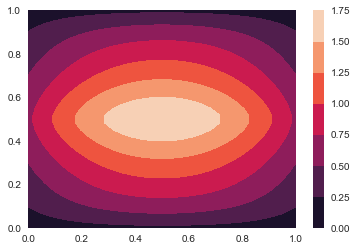

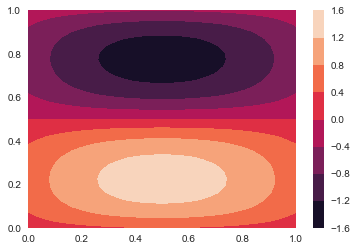

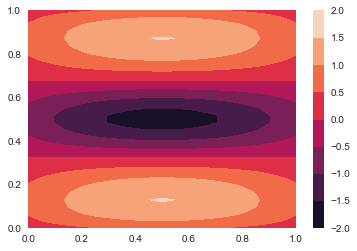

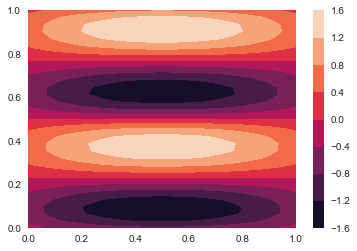

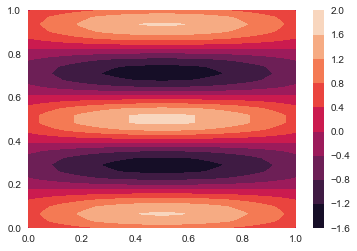

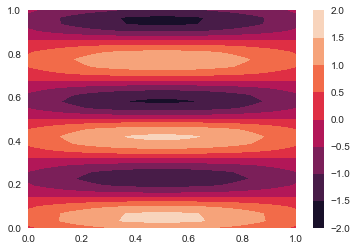

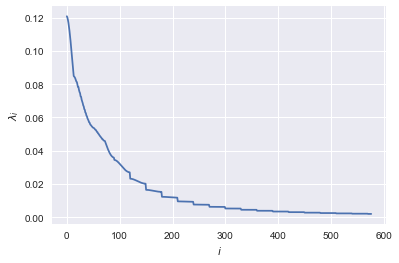

In [161]:
# The input dimension
dim = 2
# The variance of the covariance kernel
variance = 3.2**2
# The lengthscale of the covariance kernel
ell1= 50./356
ell2= 10./670
# Generate the covariance object
k = GPy.kern.Exponential(dim, ARD=True, variance=variance, lengthscale=[ell1,ell2])
kle = KarhunenLoeveExpansion(k, nq=950, alpha=0.95)
x = np.linspace(0, 1, 32)
X1, X2 = np.meshgrid(x, x)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print 'Number of terms:', kle.num_xi
# Let's look at them
Phi = kle.eval_phi(X_all)
#print Phi
for i in xrange(6):
    fig, ax = plt.subplots()
    c = ax.contourf(X1, X2, Phi[:, i].reshape(X1.shape))
    plt.colorbar(c)
fig, ax = plt.subplots()
ax.plot(kle.lam)
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

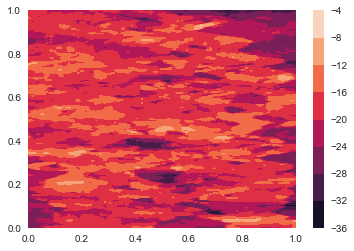

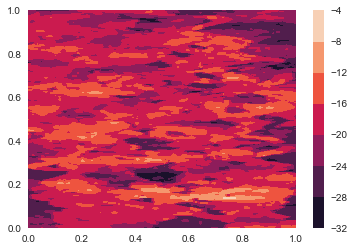

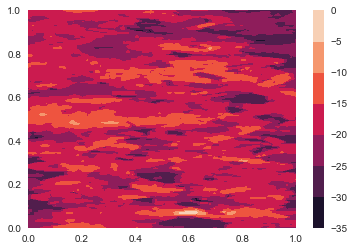

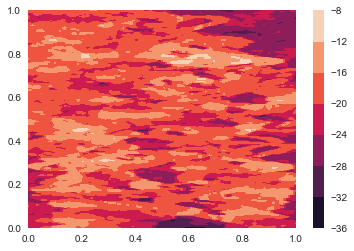

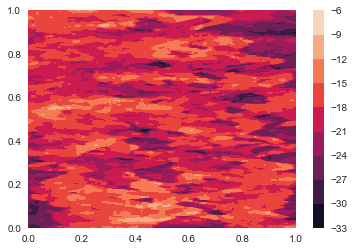

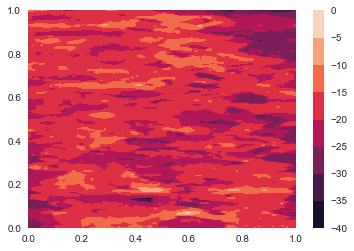

In [162]:
x1 = np.linspace(0, 1, 60)
x2 = np.linspace(0, 1, 220)
X1, X2 = np.meshgrid(x1, x2)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
m=np.log(K)
for i in xrange(6):
    fig, ax = plt.subplots()
    xi = np.random.randn(kle.num_xi)
    f =m+kle(X_all, xi).reshape(X1.shape)
    c = ax.contourf(X1, X2,f)
    plt.colorbar(c)

[[ 0.28089888  0.29850746]
 [ 0.84269663  0.74626866]]
[-13.2 -25.3]
Number of terms: 578


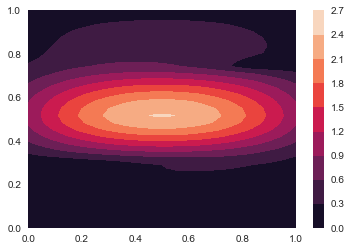

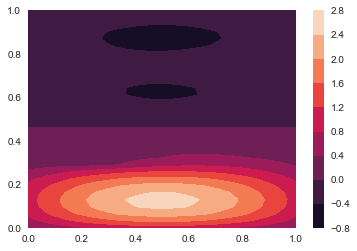

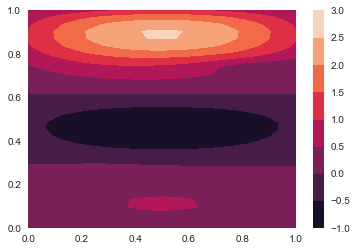

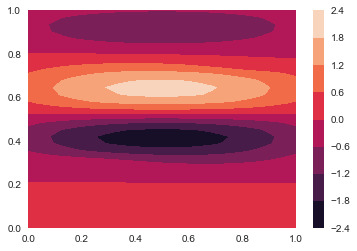

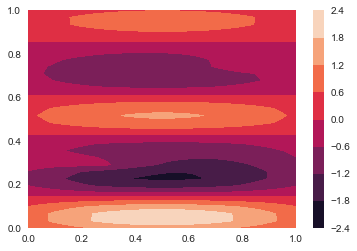

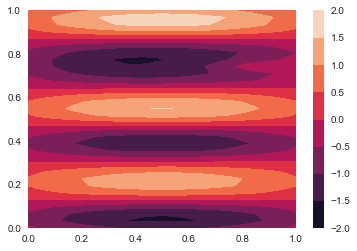

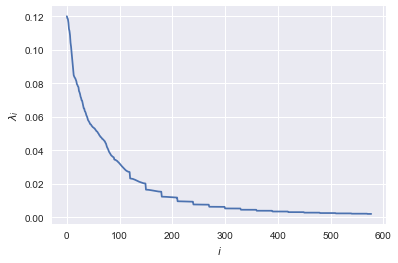

In [163]:
X = np.random.randn(2, 2)
X[0,0]=100/356.
X[1,0]=300/356.
X[0,1]=200/670.
X[1,1]=500/670.
Y= np.random.randn(2)
Y[0]=(-13.2)
Y[1]=(-25.3)
print X
print Y
kle = KarhunenLoeveExpansion(k, nq=950, alpha=0.95, X=X, Y=Y)
x = np.linspace(0, 1, 32)
X1, X2 = np.meshgrid(x, x)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print 'Number of terms:', kle.num_xi
# Let's look at them
Phi = kle.eval_phi(X_all)
for i in xrange(6):
    fig, ax = plt.subplots()
    c = ax.contourf(X1, X2, Phi[:, i].reshape(X1.shape))
#ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
    plt.colorbar(c)
fig, ax = plt.subplots()
ax.plot(kle.lam)
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

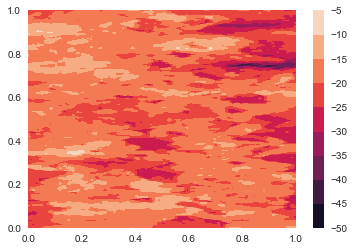

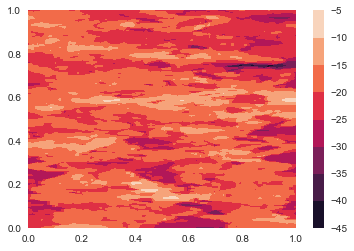

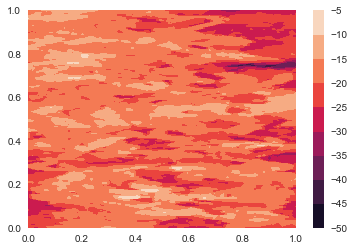

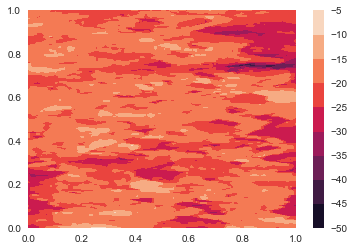

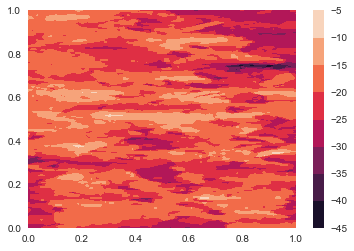

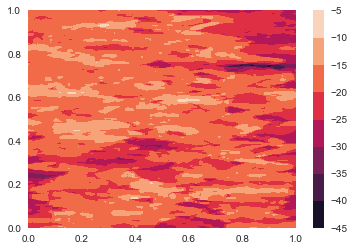

In [164]:
x1 = np.linspace(0, 1, 60)
x2 = np.linspace(0, 1, 220)
X1, X2 = np.meshgrid(x1, x2)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
m=np.log(K)
for i in xrange(6):
    fig, ax = plt.subplots()
    xi = np.random.randn(kle.num_xi)
#print xi
    f =m+kle(X_all, xi).reshape(X1.shape)
    c = ax.contourf(X1, X2,f)
    plt.colorbar(c)